In [1]:
VALIDATE = True

MAX_ROUNDS = 1000
EARLY_STOP = 50
OPT_ROUNDS = 680

path = '../input/'
FULL_OUTFILE = '../output/lgbt0417_dev.csv'
VALID_OUTFILE = '../output/lgbt0417_dev_vaild.csv'

import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split 
import lightgbm as lgb

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

print('load train...')
train_cols = ['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
train_df = pd.read_csv(path+"train_sample.csv", dtype=dtypes, usecols=train_cols)

load train...


In [2]:
train_df.head()

,ip,app,device,os,channel,click_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,0
1,105560,25,1,17,259,2017-11-07 13:40:27,0
2,101424,12,1,19,212,2017-11-07 18:05:24,0
3,94584,13,1,13,477,2017-11-07 04:58:08,0
4,68413,12,1,1,178,2017-11-09 09:00:09,0


In [56]:
train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')
train_df['weekday'] = pd.to_datetime(train_df.click_time).dt.weekday.astype('uint8')

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

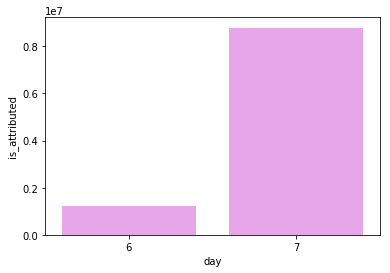

In [25]:
ax = plt.axes()
data = train_df.groupby(['day'])[['is_attributed']].count()
sns.barplot(x=data.index, y=data['is_attributed'], alpha=0.8, color='violet', ax=ax)

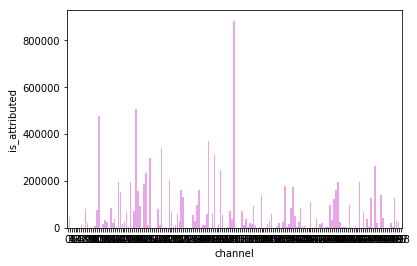

In [102]:
ax = plt.axes()
data = train_df.groupby(['channel'])[['is_attributed']].count()
sns.barplot(x=data.index, y=data['is_attributed'], alpha=0.8, color='violet', ax=ax)

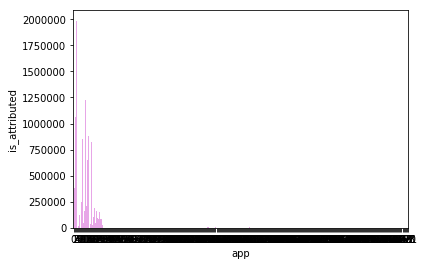

In [104]:
ax = plt.axes()
data = train_df.groupby(['app'])[['is_attributed']].count()
sns.barplot(x=data.index, y=data['is_attributed'], alpha=0.8, color='violet', ax=ax)

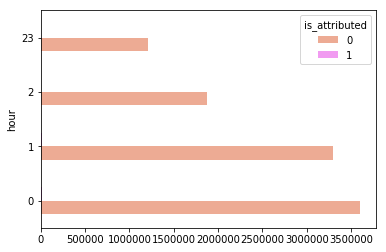

In [101]:
temp = pd.crosstab(train_df.hour, train_df.is_attributed)
temp.plot(kind='barh', stacked=False, color=['darksalmon', 'violet'],alpha = 0.8, grid=False)
plt.show()

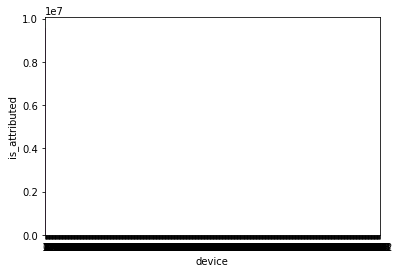

In [106]:
ax = plt.axes()
data = train_df.groupby(['device'])[['is_attributed']].count()
sns.barplot(x=data.index, y=data['is_attributed'], alpha=0.8, color='violet', ax=ax)

In [10]:
train_df.corr()

,ip,app,device,os,channel,is_attributed,hour,day,weekday
ip,1.000000,0.007742,-0.004462,-0.004084,0.007451,0.023031,-0.000950,0.001723,0.001723
app,0.007742,1.000000,0.132729,0.132588,-0.030494,0.064376,0.018935,-0.020245,-0.020245
device,-0.004462,0.132729,1.000000,0.971669,-0.088402,-0.002412,0.003919,-0.003776,-0.003776
os,-0.004084,0.132588,0.971669,1.000000,-0.084470,-0.002944,0.004808,-0.004661,-0.004661
channel,0.007451,-0.030494,-0.088402,-0.084470,1.000000,-0.040254,-0.015125,0.017582,0.017582
is_attributed,0.023031,0.064376,-0.002412,-0.002944,-0.040254,1.000000,-0.006412,0.007331,0.007331
hour,-0.000950,0.018935,0.003919,0.004808,-0.015125,-0.006412,1.000000,-0.995121,-0.995121
day,0.001723,-0.020245,-0.003776,-0.004661,0.017582,0.007331,-0.995121,1.000000,1.000000
weekday,0.001723,-0.020245,-0.003776,-0.004661,0.017582,0.007331,-0.995121,1.000000,1.000000


In [107]:
print('group by : ip, weekday, hour')
gp = train_df[['ip', 'weekday', 'hour', 'channel']]\
    .groupby(by=['ip', 'weekday', 'hour'])[['channel']]\
    .count().reset_index()\
    .rename(index=str, columns={'channel': 'ip_wday_hour'})
train_df = train_df.merge(gp, on=['ip','weekday', 'hour'], how='left')

group by : ip, weekday, hour


In [108]:
train_df.head()

,ip,app,device,os,channel,click_time,is_attributed,hour,day,weekday,ip_wday_hour
0,143657,18,1,28,107,2017-11-06 23:32:57,0,23,6,0,53
1,4701,26,1,13,121,2017-11-06 23:32:57,0,23,6,0,142
2,175744,3,1,13,480,2017-11-06 23:32:57,0,23,6,0,55
3,8391,15,1,17,245,2017-11-06 23:32:57,0,23,6,0,343
4,121087,64,1,1,459,2017-11-06 23:32:57,0,23,6,0,50


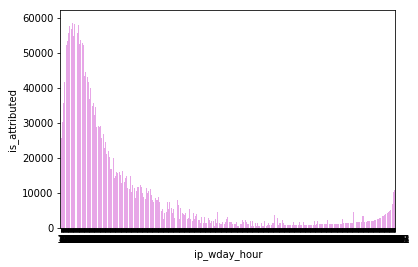

In [109]:
ax = plt.axes()
data = train_df.groupby(['ip_wday_hour'])[['is_attributed']].count()
sns.barplot(x=data.index, y=data['is_attributed'], alpha=0.8, color='violet', ax=ax)

In [110]:
most_freq_hours_in_test_data = [4, 5, 9, 10, 13, 14]
least_freq_hours_in_test_data = [6, 11, 15]
train_df['in_test_hh'] = (3 
                             - 2 * train_df['hour'].isin(most_freq_hours_in_test_data) 
                             - 1 * train_df['hour'].isin(least_freq_hours_in_test_data)).astype('uint8')

In [111]:
print('group by : ip, weekday, in_test_hh')
gp = train_df[['ip', 'weekday', 'in_test_hh', 'channel']]\
    .groupby(by=['ip', 'weekday', 'in_test_hh'])[['channel']]\
    .count().reset_index()\
    .rename(index=str, columns={'channel': 'ip_wday_test_hh'})
train_df = train_df.merge(gp, on=['ip','weekday', 'in_test_hh'], how='left')

group by : ip, weekday, in_test_hh


In [112]:
train_df.head()

,ip,app,device,os,channel,click_time,is_attributed,hour,day,weekday,ip_wday_hour,in_test_hh,ip_wday_test_hh
0,143657,18,1,28,107,2017-11-06 23:32:57,0,23,6,0,53,3,53
1,4701,26,1,13,121,2017-11-06 23:32:57,0,23,6,0,142,3,142
2,175744,3,1,13,480,2017-11-06 23:32:57,0,23,6,0,55,3,55
3,8391,15,1,17,245,2017-11-06 23:32:57,0,23,6,0,343,3,343
4,121087,64,1,1,459,2017-11-06 23:32:57,0,23,6,0,50,3,50


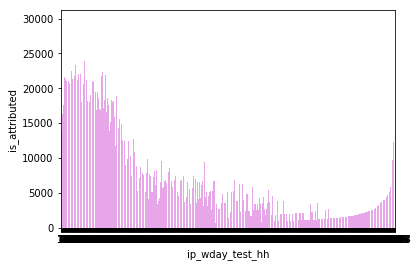

In [113]:
ax = plt.axes()
data = train_df.groupby(['ip_wday_test_hh'])[['is_attributed']].count()
sns.barplot(x=data.index, y=data['is_attributed'], alpha=0.8, color='violet', ax=ax)

In [117]:
print('group by : ip, os, hour')
gp = train_df[['ip', 'os', 'hour', 'channel']]\
    .groupby(by=['ip', 'os', 'hour'])[['channel']]\
    .count().reset_index()\
    .rename(index=str, columns={'channel': 'ip_os_hour'})
train_df = train_df.merge(gp, on=['ip','os', 'hour'], how='left')

group by : ip, os, hour


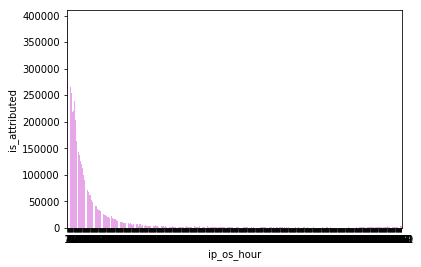

In [118]:
ax = plt.axes()
data = train_df.groupby(['ip_os_hour'])[['is_attributed']].count()
sns.barplot(x=data.index, y=data['is_attributed'], alpha=0.8, color='violet', ax=ax)

In [119]:
print('group by : ip, app, hour')
gp = train_df[['ip', 'app', 'hour', 'channel']]\
    .groupby(by=['ip', 'app', 'hour'])[['channel']]\
    .count().reset_index()\
    .rename(index=str, columns={'channel': 'ip_app_hour'})
train_df = train_df.merge(gp, on=['ip','app', 'hour'], how='left')

group by : ip, app, hour


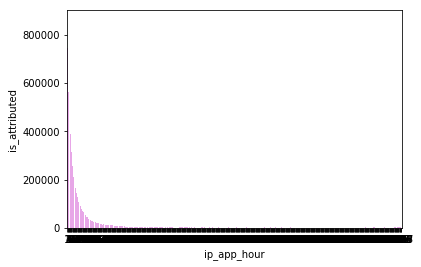

In [120]:
ax = plt.axes()
data = train_df.groupby(['ip_app_hour'])[['is_attributed']].count()
sns.barplot(x=data.index, y=data['is_attributed'], alpha=0.8, color='violet', ax=ax)

In [121]:
print('group by : ip, device, hour')
gp = train_df[['ip', 'device', 'hour', 'channel']]\
    .groupby(by=['ip', 'device', 'hour'])[['channel']]\
    .count().reset_index()\
    .rename(index=str, columns={'channel': 'ip_device_hour'})
train_df = train_df.merge(gp, on=['ip','device', 'hour'], how='left')

group by : ip, device, hour


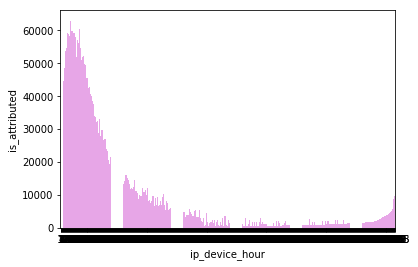

In [122]:
ax = plt.axes()
data = train_df.groupby(['ip_device_hour'])[['is_attributed']].count()
sns.barplot(x=data.index, y=data['is_attributed'], alpha=0.8, color='violet', ax=ax)

In [123]:
print('group by : os, app, hour')
gp = train_df[['os', 'app', 'hour', 'channel']]\
    .groupby(by=['os', 'app', 'hour'])[['channel']]\
    .count().reset_index()\
    .rename(index=str, columns={'channel': 'os_app_hour'})
train_df = train_df.merge(gp, on=['os','app', 'hour'], how='left')

group by : os, app, hour


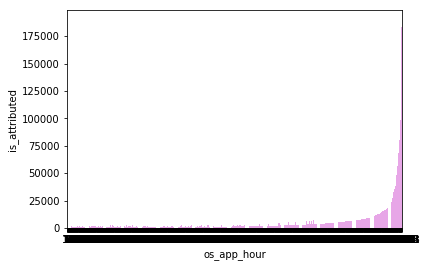

In [124]:
ax = plt.axes()
data = train_df.groupby(['os_app_hour'])[['is_attributed']].count()
sns.barplot(x=data.index, y=data['is_attributed'], alpha=0.8, color='violet', ax=ax)

In [125]:
train_df.head()

,ip,app,device,os,channel,click_time,is_attributed,hour,day,weekday,ip_wday_hour_x,in_test_hh,ip_wday_test_hh,ip_wday_hour_y,ip_os_hour,ip_app_hour,ip_device_hour,os_app_hour
0,143657,18,1,28,107,2017-11-06 23:32:57,0,23,6,0,53,3,53,16,16,18,53,640
1,4701,26,1,13,121,2017-11-06 23:32:57,0,23,6,0,142,3,142,30,30,3,141,4331
2,175744,3,1,13,480,2017-11-06 23:32:57,0,23,6,0,55,3,55,14,14,8,55,32647
3,8391,15,1,17,245,2017-11-06 23:32:57,0,23,6,0,343,3,343,5,5,18,343,6306
4,121087,64,1,1,459,2017-11-06 23:32:57,0,23,6,0,50,3,50,5,5,4,50,193


In [127]:
print('group by : os, wday, hour')
gp = train_df[['os', 'weekday', 'hour', 'channel']]\
    .groupby(by=['os', 'weekday', 'hour'])[['channel']]\
    .count().reset_index()\
    .rename(index=str, columns={'channel': 'os_wday_hour'})
train_df = train_df.merge(gp, on=['os','weekday', 'hour'], how='left')

group by : os, wday, hour


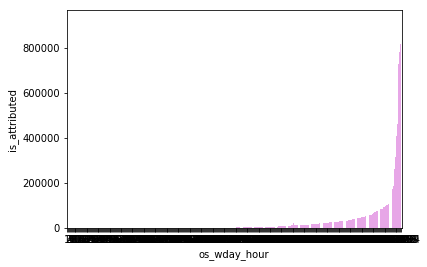

In [128]:
ax = plt.axes()
data = train_df.groupby(['os_wday_hour'])[['is_attributed']].count()
sns.barplot(x=data.index, y=data['is_attributed'], alpha=0.8, color='violet', ax=ax)

In [129]:
print('group by : app, wday, hour')
gp = train_df[['app', 'weekday', 'hour', 'channel']]\
    .groupby(by=['app', 'weekday', 'hour'])[['channel']]\
    .count().reset_index()\
    .rename(index=str, columns={'channel': 'app_wday_hour'})
train_df = train_df.merge(gp, on=['app','weekday', 'hour'], how='left')

group by : app, wday, hour


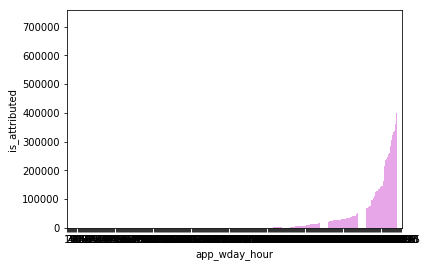

In [130]:
ax = plt.axes()
data = train_df.groupby(['app_wday_hour'])[['is_attributed']].count()
sns.barplot(x=data.index, y=data['is_attributed'], alpha=0.8, color='violet', ax=ax)

In [ ]:
def merge_feature():
    print('group by : ip, os, hour')
    gp = train_df[['ip', 'os', 'hour', 'channel']]\
        .groupby(by=['ip', 'os', 'hour'])[['channel']]\
        .count().reset_index()\
        .rename(index=str, columns={'channel': 'ip_os_hour'})
    train_df = train_df.merge(gp, on=['ip','os', 'hour'], how='left')
    
    print('group by : ip, app, hour')
    gp = train_df[['ip', 'app', 'hour', 'channel']]\
        .groupby(by=['ip', 'app', 'hour'])[['channel']]\
        .count().reset_index()\
        .rename(index=str, columns={'channel': 'ip_app_hour'})
    train_df = train_df.merge(gp, on=['ip','app', 'hour'], how='left')
    
    print('group by : os, app, hour')
    gp = train_df[['os', 'app', 'hour', 'channel']]\
        .groupby(by=['os', 'app', 'hour'])[['channel']]\
        .count().reset_index()\
        .rename(index=str, columns={'channel': 'os_app_hour'})
    train_df = train_df.merge(gp, on=['os','app', 'hour'], how='left')
    
    print('group by : os, wday, hour')
    gp = train_df[['os', 'weekday', 'hour', 'channel']]\
        .groupby(by=['os', 'weekday', 'hour'])[['channel']]\
        .count().reset_index()\
        .rename(index=str, columns={'channel': 'os_wday_hour'})
    train_df = train_df.merge(gp, on=['os','weekday', 'hour'], how='left')
    
    print('group by : app, wday, hour')
    gp = train_df[['app', 'weekday', 'hour', 'channel']]\
        .groupby(by=['app', 'weekday', 'hour'])[['channel']]\
        .count().reset_index()\
        .rename(index=str, columns={'channel': 'app_wday_hour'})
    train_df = train_df.merge(gp, on=['app','weekday', 'hour'], how='left')
    
    